Parameters

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
source_folder = '/content/drive/My Drive/github_repos/Fake-news-detection-VN/Data'
destination_folder = '/content/drive/My Drive/github_repos/Fake-news-detection-VN/Model-multi'

Libraries

In [4]:
!pip install transformers

     |████████████████████████████████| 1.3MB 8.2MB/s 
     |████████████████████████████████| 2.9MB 53.9MB/s 
     |████████████████████████████████| 1.1MB 49.0MB/s 
     |████████████████████████████████| 890kB 51.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=a3e8db168422b2da023b87daf8f8e1f7edf759ab305c3f6b8bbcf8dcc752c126
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
# CUDA_LAUNCH_BLOCKING="1"

Preliminaries

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [9]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)

user_name_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)

post_message_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)

timestamp_post_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)

fields = [('label', label_field),('user_name', user_name_field), ('post_message', post_message_field), ('timestamp_post', timestamp_post_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.post_message),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.post_message),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=32, device=device, train=False, shuffle=False, sort=False)

# **Model**

In [10]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-multilingual-cased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

# **Training**

In [11]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [44]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 4,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, user_name, post_message, timestamp_post), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)

            user_name = user_name.type(torch.LongTensor)           
            user_name = user_name.to(device)

            post_message = post_message.type(torch.LongTensor)  
            post_message = post_message.to(device)

            timestamp_post = timestamp_post.type(torch.LongTensor)  
            timestamp_post = timestamp_post.to(device)

            output = model(post_message, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, user_name, post_message, timestamp_post), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)

                        user_name = user_name.type(torch.LongTensor)           
                        user_name = user_name.to(device)

                        post_message = post_message.type(torch.LongTensor)  
                        post_message = post_message.to(device)

                        timestamp_post = timestamp_post.type(torch.LongTensor)  
                        timestamp_post = timestamp_post.to(device)

                        output = model(post_message, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [45]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Epoch [1/4], Step [55/440], Train Loss: 0.3797, Valid Loss: 0.4629
Model saved to ==> /content/drive/My Drive/github_repos/Fake-news-detection-VN/Model-multi/model.pt
Model saved to ==> /content/drive/My Drive/github_repos/Fake-news-detection-VN/Model-multi/metrics.pt
Epoch [1/4], Step [110/440], Train Loss: 0.4709, Valid Loss: 0.5356
Epoch [2/4], Step [165/440], Train Loss: 0.3638, Valid Loss: 0.4607
Model saved to ==> /content/drive/My Drive/github_repos/Fake-news-detection-VN/Model-multi/model.pt
Model saved to ==> /content/drive/My Drive/github_repos/Fake-news-detection-VN/Model-multi/metrics.pt
Epoch [2/4], Step [220/440], Train Loss: 0.4079, Valid Loss: 0.6513
Epoch [3/4], Step [275/440], Train Loss: 0.3554, Valid Loss: 0.3808
Model saved to ==> /content/drive/My Drive/github_repos/Fake-news-detection-VN/Model-multi/model.pt
Model saved to ==> /content/drive/My Drive/github_repos/Fake-news-detection-VN/Model-multi/metrics.pt
Epoch [3/4], Step [330/440], Train Loss: 0.3705, Valid 

Model loaded from <== /content/drive/My Drive/github_repos/Fake-news-detection-VN/Model-multi/metrics.pt


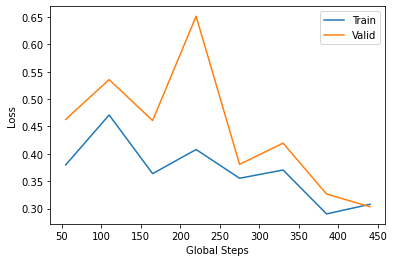

In [46]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# **Evaluation**

In [47]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, user_name, post_message, timestamp_post), _ in test_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)

            user_name = user_name.type(torch.LongTensor)           
            user_name = user_name.to(device)

            post_message = post_message.type(torch.LongTensor)  
            post_message = post_message.to(device)

            timestamp_post = timestamp_post.type(torch.LongTensor)  
            timestamp_post = timestamp_post.to(device)

            output = model(post_message, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Greens', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Model loaded from <== /content/drive/My Drive/github_repos/Fake-news-detection-VN/Model-multi/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.6614    0.5714    0.6131       147
           0     0.9158    0.9409    0.9282       728

    accuracy                         0.8789       875
   macro avg     0.7886    0.7562    0.7707       875
weighted avg     0.8730    0.8789    0.8753       875



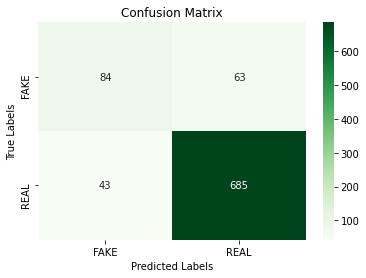

In [48]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)

# **Evaluate AUC ROC**

In [54]:
# Evaluation Function
import sklearn.metrics as metrics
from sklearn.metrics import auc, roc_curve

def evaluate_ROC(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, user_name, post_message, timestamp_post), _ in test_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)

            user_name = user_name.type(torch.LongTensor)           
            user_name = user_name.to(device)

            post_message = post_message.type(torch.LongTensor)  
            post_message = post_message.to(device)

            timestamp_post = timestamp_post.type(torch.LongTensor)  
            timestamp_post = timestamp_post.to(device)

            output = model(post_message, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())
    
# Tính toán auc
    fpr, tpr, thres = metrics.roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Model loaded from <== /content/drive/My Drive/github_repos/Fake-news-detection-VN/Model-multi/model.pt


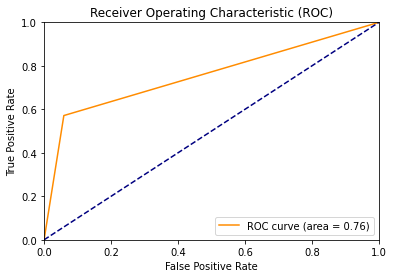

In [55]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate_ROC(best_model, test_iter)